In [12]:
import pandas as pd
import numpy as np
import ast
import re
from collections import defaultdict

### load business data and review data

In [13]:
trainSize=1000
business_train = pd.read_json('..//data//business_train.json',orient = 'records',lines = True)
review_train=pd.read_json('..//data//review_train.json',orient='records',lines=True,chunksize=trainSize)



### preserve business_id, stars columns and save it to local json files

In [39]:
# count=2
# res=next(review_train).iloc[:,[0,2]]
# for reviewTrainChunk in review_train:
#     print("processing {} th chunk ...".format(count))
#     res=res.append(reviewTrainChunk.iloc[:,[0,2]])
#     count+=1
# print("finished")

processing 2 th chunk ...
processing 3 th chunk ...
processing 4 th chunk ...
processing 5 th chunk ...
processing 6 th chunk ...
processing 7 th chunk ...
processing 8 th chunk ...
processing 9 th chunk ...
processing 10 th chunk ...
processing 11 th chunk ...
processing 12 th chunk ...
processing 13 th chunk ...
processing 14 th chunk ...
processing 15 th chunk ...
processing 16 th chunk ...
processing 17 th chunk ...
processing 18 th chunk ...
processing 19 th chunk ...
processing 20 th chunk ...
processing 21 th chunk ...
processing 22 th chunk ...
processing 23 th chunk ...
processing 24 th chunk ...
processing 25 th chunk ...
processing 26 th chunk ...
processing 27 th chunk ...
processing 28 th chunk ...
processing 29 th chunk ...
processing 30 th chunk ...
processing 31 th chunk ...
processing 32 th chunk ...
processing 33 th chunk ...
processing 34 th chunk ...
processing 35 th chunk ...
processing 36 th chunk ...
processing 37 th chunk ...
processing 38 th chunk ...
processin

In [41]:
# res.shape
# res.columns

# res=res.groupby('business_id',as_index=False).mean()

# res.to_json("average_star_by_shops.json",orient='records')

Index(['business_id', 'stars'], dtype='object')

In [3]:
shop_stars=pd.read_json("average_star_by_shops.json",orient="records")

### Extract nested json data from business data

In [4]:
def nestedValue(x:str):
    """judge if a string contains nested json information"""
    return re.match(u'{.*}',x)

### first extract the column names from nested json
colnames=[]
for attribute in business_train.attributes:
    if attribute==None:
        continue
    for key,value in attribute.items():
        if not nestedValue(value):
            colnames.append(key)
        else:
            for nestKey,nestValue in ast.literal_eval(value).items():
                colnames.append(nestKey)
colnames=set(colnames)

### second extract the value from nested json file
res=defaultdict(list)
count=0
for attribute in business_train.attributes:
    
    
    for i in colnames:
        res[i].append(None)
    if attribute==None:
        count+=1
        continue
    for key,value in attribute.items():
        if not nestedValue(value):
            res[key][count]=value
        else:
            for nestKey,nestValue in ast.literal_eval(value).items():
                res[nestKey][count]=nestValue
            
        
    count+=1 

attributeTrain=pd.DataFrame(res)

attributeTrain['business_id']=business_train.business_id

### join business data and review rating on business_id

In [5]:
attributeTrain=attributeTrain.join(shop_stars.set_index('business_id'),on="business_id",how='left')

### data cleaning, drop columns with many NAs, convert string to category 

In [6]:
attributeTrainReduced=attributeTrain.dropna(thresh=len(attributeTrain)*0.2, axis=1)

attributeTrainReduced=attributeTrainReduced.drop("business_id",axis=1);

attributeTrainReduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154606 entries, 0 to 154605
Data columns (total 31 columns):
divey                         31984 non-null object
RestaurantsAttire             38964 non-null object
classy                        38039 non-null object
RestaurantsGoodForGroups      43803 non-null object
garage                        81327 non-null object
ByAppointmentOnly             37709 non-null object
touristy                      38039 non-null object
RestaurantsDelivery           42027 non-null object
intimate                      38039 non-null object
BusinessAcceptsCreditCards    90752 non-null object
RestaurantsTakeOut            49768 non-null object
romantic                      38039 non-null object
RestaurantsReservations       41820 non-null object
Alcohol                       38726 non-null object
RestaurantsPriceRange2        86713 non-null object
WiFi                          40026 non-null object
hipster                       37538 non-null object
upsca

In [1]:
for colName in attributeTrainReduced.columns[:-1]:
    attributeTrainReduced[colName]=attributeTrainReduced[colName].astype('category')

NameError: name 'attributeTrainReduced' is not defined

In [243]:
attributeTrainReduced.iloc[:,0].values

[NaN, False, NaN, NaN, NaN, ..., False, NaN, NaN, NaN, NaN]
Length: 154606
Categories (2, object): [False, True]

### try fit a simple linear regression

In [245]:
pd.get_dummies(attributeTrainReduced).iloc[:5,:]

,stars,hipster_False,hipster_True,BikeParking_False,BikeParking_None,BikeParking_True,upscale_False,upscale_True,RestaurantsReservations_False,RestaurantsReservations_None,...,garage_True,WiFi_'free',WiFi_'no',WiFi_'paid',WiFi_None,WiFi_u'free',WiFi_u'no',WiFi_u'paid',touristy_False,touristy_True
0,3.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.073034,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,5.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.666667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(attributeTrainReduced).iloc[:,1:],pd.get_dummies(attributeTrainReduced).iloc[:,0],  random_state=0)

In [250]:
modelSlr = LinearRegression().fit(X_train, y_train)
pred=modelSlr.predict(X_test)
print("the score(rmse) is {}".format(np.sqrt(mean_squared_error(pred,y_test))))

the score(rmse) is 0.9707625101864331


### round the rating value and use a multioutcome logistic regression

In [18]:
# here, we need to make continuous ylabel to be categorical variable
y_train_class=np.round(y_train)
y_test_class=np.round(y_test)
from sklearn.linear_model import LogisticRegression

modelLr=LogisticRegression(multi_class='multinomial',solver='newton-cg')
modelLr.fit(X_train,y_train_class)
pred=modelLr.predict(X_test)
print("the score is {}".format(mean_squared_error(pred,y_test_class)))

the score is 1.539661595777709


### Linear Discriminant Analysis  (different from zihan's latent dirichlet allocation topic model)
Here, we would like to select a few dimensions, each dimension is a linear combination of the business attribute, that separate the most of five classes.

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
modelLda = LinearDiscriminantAnalysis(n_components=2)

modelLda.fit(X_train,y_train_class)
temp=modelLda.transform(X_test)
print(temp)

modelLda.fit(X_train,y_train_class)
pred=modelLda.predict(X_test)
print("the score(rmse) is {}".format(np.sqrt(mean_squared_error(pred,y_test_class))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[[ 1.00123893 -0.25369133]
 [ 1.59270811 -0.08063106]
 [ 0.01992471  0.22367829]
 ...
 [-1.55385298 -0.14773515]
 [ 1.4143175  -0.22847774]
 [-0.54162173 -1.00670004]]
the score(rmse) is 1.1929520683062702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [0.60515607 0.31092162]


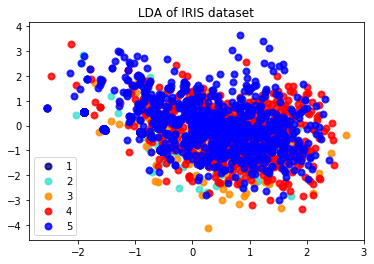

In [22]:
import matplotlib.pyplot as plt
X_test_transform= modelLda.transform(X_test)
target_names=[1,2,3,4,5]
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(modelLda.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','red','blue']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2,3,4], target_names):
    plt.scatter(X_test_transform[y_test == i, 0], X_test_transform[y_test == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [15]:
for i,j in zip([1,2],[3,4]):
    print(i,j)

1 3
2 4


### use randomforest to have a glimpse at feature importance

In [326]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline            

modelRfc = RandomForestClassifier()
modelRfc.fit(X_train, y_train_class)

pred=modelRfc.predict(X_test)
print("the score(rmse) is {}".format(np.sqrt(mean_squared_error(pred,y_test_class))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


the score(rmse) is 1.2519156386201389


the prediction is better than logistic regression

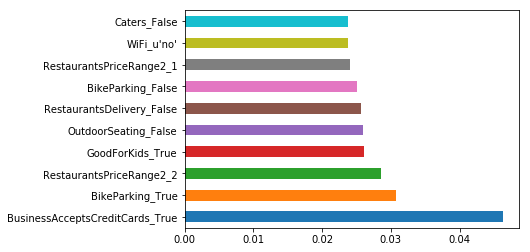

In [327]:
pd.Series(modelRfc.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh')

some variables actually make sense, so we extract a single tree from the forest to visualize it.

In [316]:
from sklearn.tree import export_graphviz
# Extract single tree
estimator = modelRfc.estimators_[5]

# Export to dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X_train.columns,
                
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png
import os
os.system('dot -Tpng tree.dot -o tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### check the meaning of each variable and do variable selection

In [311]:
for i in attributeTrainReduced.columns[:-1]:
    print("--------------------------------------------------------------------")
    category=pd.unique(attributeTrainReduced[i])
    if (True in category and False in category) or ("True" in category and "False" in category):
        for subClass in category:
            subClassRate=round(np.sum(attributeTrainReduced[i]==subClass)/attributeTrainReduced.shape[0]*100,2)
            subClassStar=round(np.mean(attributeTrainReduced.stars[attributeTrainReduced[i]==subClass]),2)
            print("For {},{}% shops are {}, the average ratings are {}".format(i,subClassRate,subClass,subClassStar))
        if np.mean(attributeTrainReduced.stars[attributeTrainReduced[i].isin([True,"True"])])>np.mean(attributeTrainReduced.stars[attributeTrainReduced[i].isin(["False",False])]):
            print("Shops have True value for {} tend to have higher ratings".format(i))
        else:
            print("Shops have False value for {} tend to have higher ratings".format(i))
    else:
        for subClass in category:
            subClassRate=round(np.sum(attributeTrainReduced[i]==subClass)/attributeTrainReduced.shape[0]*100,2)
            subClassStar=round(np.mean(attributeTrainReduced.stars[attributeTrainReduced[i]==subClass]),2)
            print("For {},{}% shops are {}, the average ratings are {}".format(i,subClassRate,subClass,subClassStar))



--------------------------------------------------------------------
For hipster,0.0% shops are nan, the average ratings are nan
For hipster,23.71% shops are False, the average ratings are 3.48
For hipster,0.57% shops are True, the average ratings are 3.94
Shops have True value for hipster tend to have higher ratings
--------------------------------------------------------------------
For BikeParking,0.0% shops are nan, the average ratings are nan
For BikeParking,34.48% shops are True, the average ratings are 3.7
For BikeParking,9.75% shops are False, the average ratings are 3.49
For BikeParking,0.1% shops are None, the average ratings are 3.62
Shops have True value for BikeParking tend to have higher ratings
--------------------------------------------------------------------
For upscale,0.0% shops are nan, the average ratings are nan
For upscale,24.22% shops are False, the average ratings are 3.48
For upscale,0.29% shops are True, the average ratings are 3.81
Shops have True value fo

Conclusion:

RestaurantsTakeOut: False is better

touristy: False is better

BusinessAcceptsCreditCards : False is better (why)

RestaurantsAttire: formal is better

NoiseLevel: quiet is better

### PCA

In [14]:
import numpy as np
from sklearn.decomposition import PCA
modelPca = PCA(n_components=2)
modelPca.fit(X_train)
print(modelPca.components_.shape)
print(modelPca.explained_variance_ratio_)
print(modelPca.components_[0,:])

(2, 96)
[0.38776649 0.11472984]
[ 2.05337243e-01  5.14539223e-03  8.26301108e-02  1.50147062e-03
  1.03080694e-04 -6.21942451e-06  1.38927472e-01  3.40994626e-03
  2.08589537e-04  2.38309898e-01  4.65671753e-03  2.50629284e-02
 -1.49145521e-05  2.14747486e-01  1.91690754e-01  8.77587716e-03
 -3.21037492e-02 -2.33401696e-04 -4.40009941e-02  2.41645424e-01
  1.32119179e-03  1.71520224e-01  3.33932019e-05  5.12272417e-02
  2.40011217e-01  2.95539887e-03 -7.80690677e-03 -1.02210986e-04
  4.70048933e-02  1.01158078e-02 -1.24293813e-05  2.15259473e-01
  2.40422887e-01  2.54372868e-03  1.41891123e-01  3.98172019e-05
  9.00290308e-02  9.29803230e-03  1.57276554e-02  2.78552066e-02
  1.03490681e-04  2.28375823e-02  7.63750603e-02  7.37573250e-02
  8.59721198e-02  1.07178221e-01  2.66595902e-03 -4.78603579e-04
 -8.37283996e-05  3.24342984e-02  3.80118257e-02  5.19920309e-04
  1.60274563e-04  5.81049411e-02  6.74228542e-02  6.04811740e-04
  2.35482626e-01  5.17188573e-03  2.40114848e-01  2.060140

### Cluster into several topic models using Latent dirichlet allocation

### Latent dirichlet allocation for review topic extraction based on tfidf vector

First step is to do data preprocessing. See our Tfidf.ipynb for more details. To make things simple, we import some packages here. When submitting the final version, pay attention not to use these packages !

In [34]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ykh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [ ]:
# load a small fractio of review data
reviewTrain=next(review_train)

In [38]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result
reviewProcessed = reviewTrain.text.map(preprocess)

In [39]:
reviewProcessed[:10]

0    [total, horribl, servic, crook, actual, nerv, ...
1    [ador, travi, hard, rock, kelli, cardena, salo...
2    [offic, organ, friend, phillipp, great, dentis...
3    [go, lunch, steak, sandwich, delici, caesar, s...
4    [today, second, session, pay, session, go, tel...
5    [admit, excit, go, tavolta, food, snob, group,...
6    [traci, dessert, hong, kong, markham, place, y...
7    [place, go, hill, clear, staff, food, qualiti,...
8                   [giant, best, regist, deal, place]
9    [like, walk, time, saturday, morn, sister, bow...
Name: text, dtype: object

In [40]:
reviewDict= gensim.corpora.Dictionary(reviewProcessed)
reviewDict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # filter extreme values, which occurs very few

In [42]:
reviewCorpus = [reviewDict.doc2bow(review) for review in reviewProcessed]
reviewCorpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 1)]

For example:

In [44]:
reviewFirst=reviewCorpus[0]
for i in range(len(reviewFirst)):
    print("Word {} (\"{}\") appears {} time.".format(reviewFirst[i][0], 
                                                     reviewDict[reviewFirst[i][0]], 
                                                     reviewFirst[i][1]))

Word 0 ("actual") appears 1 time.
Word 1 ("avoid") appears 1 time.
Word 2 ("cent") appears 1 time.
Word 3 ("charg") appears 1 time.
Word 4 ("check") appears 1 time.
Word 5 ("cost") appears 1 time.
Word 6 ("crook") appears 1 time.
Word 7 ("horribl") appears 1 time.
Word 8 ("hospit") appears 1 time.
Word 9 ("nerv") appears 1 time.
Word 10 ("onlin") appears 1 time.
Word 11 ("pill") appears 2 time.
Word 12 ("servic") appears 1 time.
Word 13 ("total") appears 1 time.


Second step is to apply tfidf on text column, and get a tfidf vector.

In [51]:
from gensim import corpora, models

reviewTfidf = models.TfidfModel(reviewCorpus)
reviewTfidfVec=reviewTfidf[reviewCorpus] # convert to tfidf vector 


for review in reviewTfidfVec[0]: # see the tfidf score of the first review
    print(review)


(0, 0.14495158100758215)
(1, 0.19930899546263636)
(2, 0.29213274094529)
(3, 0.15823535174116202)
(4, 0.12828814743062356)
(5, 0.1798088716738824)
(6, 0.3473802395281135)
(7, 0.18550799450863834)
(8, 0.29213274094529)
(9, 0.277665658195513)
(10, 0.2079510768629125)
(11, 0.6250458977236264)
(12, 0.06004552797331273)
(13, 0.15823535174116202)


Finally, we run LDA using Bags of Words

In [ ]:
# because we have used linear discriminant analysis above, here we call the model modelTopic
modelTopic = gensim.models.LdaMulticore(reviewCorpus, num_topics=10, id2word=reviewDict, passes=2, workers=2)

In [54]:
for index, topic in modelTopic.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(index, topic))

Topic: 0 
Words: 0.017*"good" + 0.016*"food" + 0.012*"place" + 0.010*"servic" + 0.008*"order" + 0.008*"nice" + 0.007*"love" + 0.007*"chicken" + 0.006*"great" + 0.006*"staff"
Topic: 1 
Words: 0.014*"time" + 0.013*"good" + 0.011*"place" + 0.008*"come" + 0.008*"tell" + 0.007*"order" + 0.007*"great" + 0.007*"want" + 0.006*"servic" + 0.006*"know"
Topic: 2 
Words: 0.018*"place" + 0.018*"great" + 0.015*"time" + 0.014*"food" + 0.013*"good" + 0.009*"like" + 0.008*"price" + 0.007*"servic" + 0.007*"go" + 0.006*"come"
Topic: 3 
Words: 0.011*"servic" + 0.010*"great" + 0.010*"food" + 0.010*"place" + 0.009*"good" + 0.009*"friend" + 0.007*"like" + 0.007*"want" + 0.006*"go" + 0.006*"come"
Topic: 4 
Words: 0.013*"place" + 0.013*"order" + 0.013*"come" + 0.012*"food" + 0.010*"go" + 0.009*"good" + 0.009*"want" + 0.007*"say" + 0.007*"like" + 0.007*"time"
Topic: 5 
Words: 0.010*"place" + 0.010*"come" + 0.009*"order" + 0.009*"go" + 0.008*"servic" + 0.007*"good" + 0.007*"food" + 0.006*"great" + 0.005*"price" +

We cannot manully separate the topics, that's annoying !!!!!!!!!

Why not group by stars first and then do topic modeling under each group? Let's try it. (code are exactly the same, except the input data are different.)

In [61]:
for i in range(1,6):
    print("-----------------------------------------------------------")
    print("The following topic model is based on {} star reviews".format(i))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")
    reviewTrainFraction=reviewTrain[reviewTrain.stars==i]
    reviewProcessed = reviewTrainFraction.text.map(preprocess)
    reviewDict= gensim.corpora.Dictionary(reviewProcessed)
    reviewDict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # filter extreme values, which occurs very few
    reviewCorpus = [reviewDict.doc2bow(review) for review in reviewProcessed]
    reviewCorpus[0]
#     reviewFirst=reviewCorpus[0]
#     for i in range(len(reviewFirst)):
#         print("Word {} (\"{}\") appears {} time.".format(reviewFirst[i][0], 
#                                                          reviewDict[reviewFirst[i][0]], 
#                                                          reviewFirst[i][1]))

    reviewTfidf = models.TfidfModel(reviewCorpus)
    reviewTfidfVec=reviewTfidf[reviewCorpus] # convert to tfidf vector 
#     for review in reviewTfidfVec[0]: # see the tfidf score of the first review
#         print(review)

    modelTopic = gensim.models.LdaMulticore(reviewCorpus, num_topics=3, id2word=reviewDict, passes=2, workers=2)
    for index, topic in modelTopic.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(index, topic))


-----------------------------------------------------------
The following topic model is based on 1 star reviews
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Topic: 0 
Words: 0.053*"say" + 0.044*"servic" + 0.043*"tell" + 0.041*"go" + 0.033*"time" + 0.030*"know" + 0.030*"custom" + 0.028*"like" + 0.027*"work" + 0.025*"need"
Topic: 1 
Words: 0.048*"time" + 0.048*"tell" + 0.043*"wait" + 0.040*"food" + 0.038*"want" + 0.032*"like" + 0.031*"walk" + 0.030*"say" + 0.028*"peopl" + 0.027*"order"
Topic: 2 
Words: 0.051*"order" + 0.046*"place" + 0.045*"minut" + 0.042*"go" + 0.034*"food" + 0.032*"say" + 0.031*"time" + 0.030*"take" + 0.028*"come" + 0.026*"leav"
-----------------------------------------------------------
The following topic model is based on 2 star reviews
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Topic: 0 
Words: 0.111*"like" + 0.096*"price" + 0.086*"want" + 0.069*"food" + 0.066*"wasn" + 0.061*"good" + 0.054*"look" + 0.049*"better" + 0.048*"place" +

### EDA for other business data outside of business attributes

In [10]:
print("there are {} unique categories in the data".format(len(pd.unique(business_train.categories))))
pd.unique(business_train.categories)[0:10]

there are 76799 unique categories in the data


array(['Golf, Active Life', 'Sushi Bars, Restaurants, Japanese',
       'Insurance, Financial Services',
       'Plumbing, Shopping, Local Services, Home Services, Kitchen & Bath, Home & Garden, Water Heater Installation/Repair',
       'Beauty & Spas, Hair Salons',
       "Hair Salons, Hair Stylists, Barbers, Men's Hair Salons, Cosmetics & Beauty Supply, Shopping, Beauty & Spas",
       'Nail Salons, Beauty & Spas, Day Spas',
       'Beauty & Spas, Nail Salons, Day Spas, Massage',
       'Local Services, Professional Services, Computers, Shopping, Home Services, IT Services & Computer Repair, Internet Service Providers, Web Design',
       'Restaurants, Breakfast & Brunch, Mexican, Tacos, Tex-Mex, Fast Food'],
      dtype=object)

In [11]:
business_train.columns

Index(['attributes', 'business_id', 'categories', 'city', 'hours', 'is_open',
       'latitude', 'longitude', 'name', 'postal_code', 'state'],
      dtype='object')